# MODELLING PROCESS
1. Data
- Plot Time Series
- Non-Stationary -> Stationary
- ACF and PACF
    - Order Estimation: MA(q), Seasonal-MA(Q), AR(p), Seasonal-AR(P)
- Building and Fitting Models
    - Evaluation Metrics: Akaike Information Critera AIC, Squared Sum Error, Ljung-Box Test, Parsimony Principle, Residuals Analysis
- Forecasting

# 1. Data

The data is Lake Erie's monthly levels from 1921-1970 and can be found at the following link.

https://datamarket.com/data/set/22pw/monthly-lake-erie-levels-1921-1970#!ds=22pw&display=line

In [1]:
# Packages used
library(astsa)
library(dplyr)
library(forecast)

Warning message:
"package 'astsa' was built under R version 3.4.3"Warning message:
"package 'dplyr' was built under R version 3.4.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'forecast' was built under R version 3.4.4"
Attaching package: 'forecast'

The following object is masked from 'package:astsa':

    gas



In [2]:
# read in data
data <- read.csv('lake-erie.csv')$Monthly.Lake.Erie.Levels.1921...1970.%>% ts(start=c(1921,1), freq=12)

Time series analysis with SARIMA (Seasonal Auto Regressive Integrated Moving Average) works very well with normally distributed data. As we can see below, our data has pretty good normal distribution. If it wasn't normally distributed we could try to  transform it to make a normal distribution.

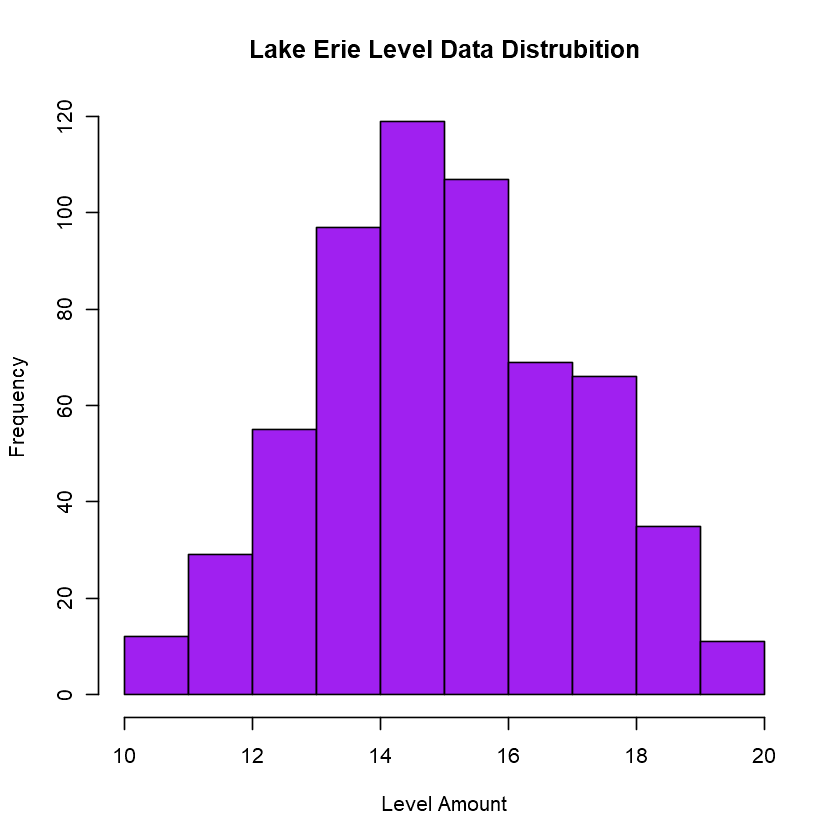

In [3]:
hist(data, main='Lake Erie Level Data Distrubition', col='purple', xlab='Level Amount')

# 2. Plot Time Series

Let's plot the data to see how it looks. We are looking for trend, change in variance, and seasonality. We clearly have a trend and the variance doesn't seem to be dependent on time; thus, there is no variance.

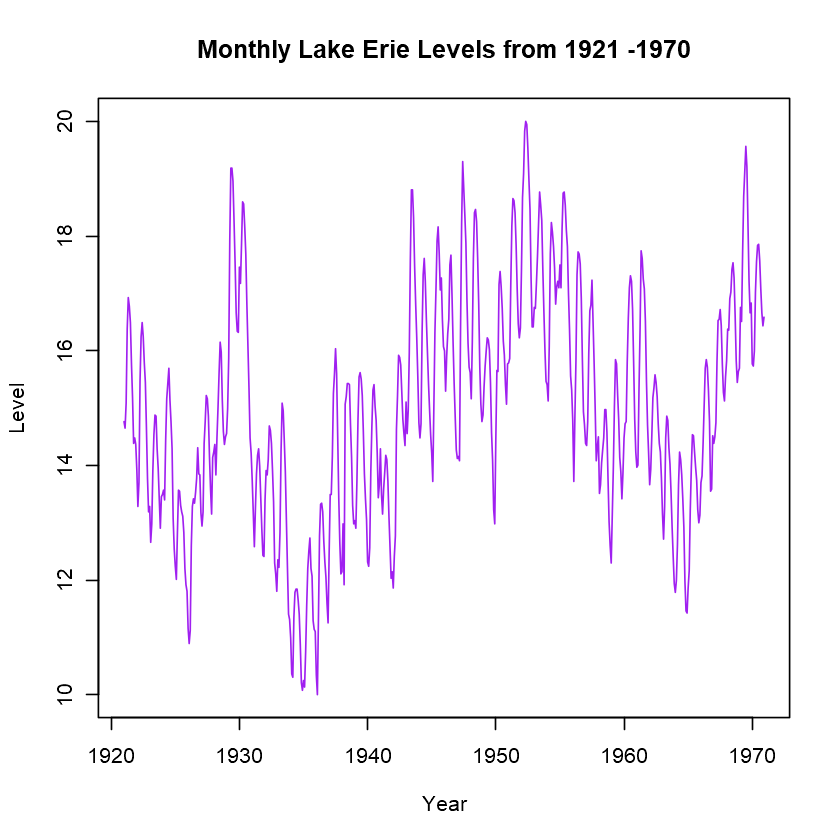

In [4]:
plot(data, main='Monthly Lake Erie Levels from 1921 -1970', xlab='Year', ylab='Level', lwd=1, col='purple')

# 3. Non-Stationary -> Stationary

To see the trend and variance of the plot more clearly we will use the decompose function to break it down. We add the argument 'additive' because our variance is independent of the level. For info and practice on additive and multiplicative seasonality http://kourentzes.com/forecasting/2014/11/09/additive-and-multiplicative-seasonality/

In [5]:
data.decomp <- decompose(data, 'additive')

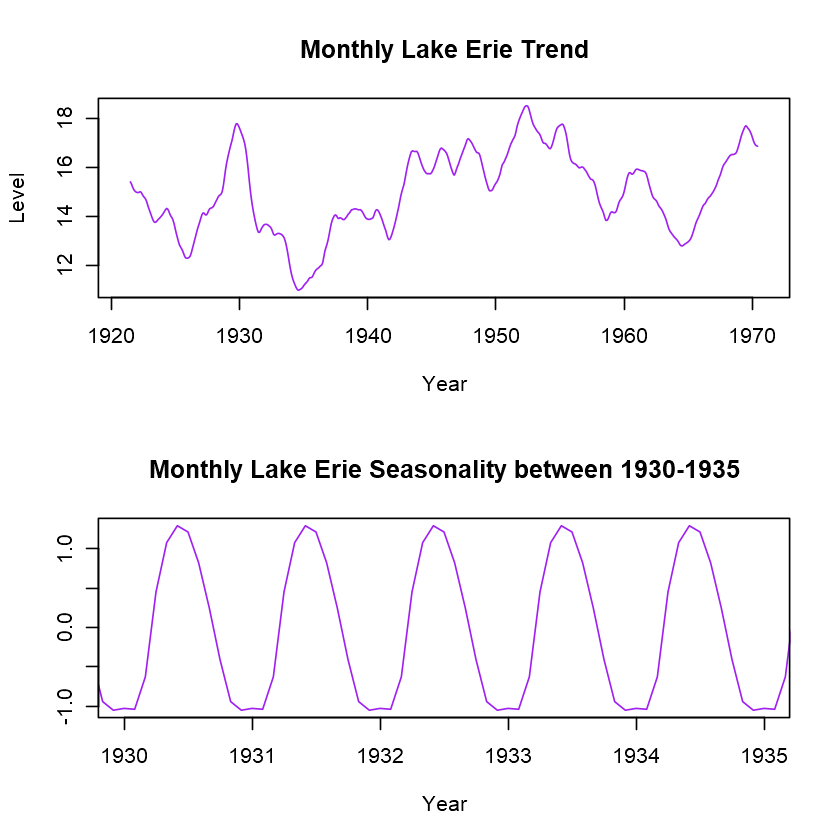

In [6]:
par(mfrow=c(2,1))
plot(data.decomp$trend, main='Monthly Lake Erie Trend', ylab='Level', xlab='Year', col='purple')
plot(data.decomp$season, main='Monthly Lake Erie Seasonality between 1930-1935', 
     ylab='', xlab='Year',xlim=c(1930,1935), col='purple')

Above, we can clearly see trend in this data along with seasonlity; and we don't have variance as seen from the raw data plot. The plots below are an alternative way of seeing the seasonality in the raw data. The Auto Correlation Function plot, ACF, clearly shows strong seasonlity patterns. In the second plot, the trend was removed from the data and zoomed in on a fixed time period from 1930-1935. Lake Erie's level dips around Oct-Nov every year showing seasonality. 

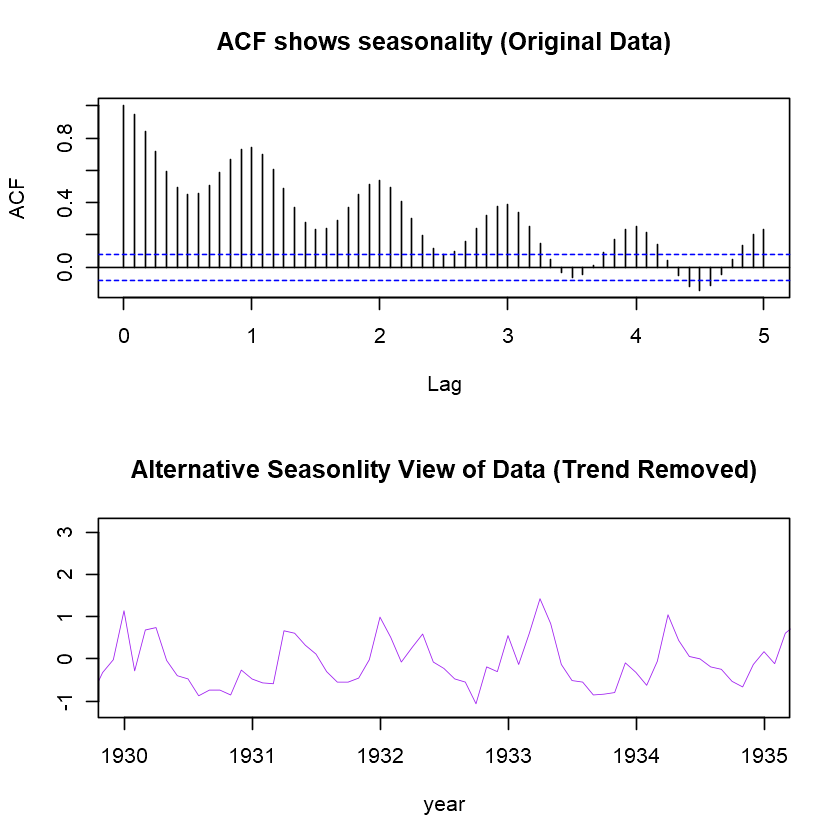

In [7]:
par(mfrow=c(2,1))
acf(data, 60, main='ACF shows seasonality (Original Data)') # add the argument "plot=F" to see the values
plot(diff(data), main='Alternative Seasonlity View of Data (Trend Removed)', 
     lwd=0.5, xlab='year', ylab='', col='purple', xlim=c(1930,1935))

In order to proceed forward with SARIMA, we must make our data stationary by removing the trend, having a constant mean of 0, and removing seasonality. We do this by differncing values. The Lake Erie dataset needs 1 non-seasoanl differencing to remove the trend and 1 seasonal differencing by 12 to remove the seasonality. Non-seasonal and seasonal differncing is usually not done more than 2 times for each type.
**If we had variance, we would remove it by taking the difference of the log.

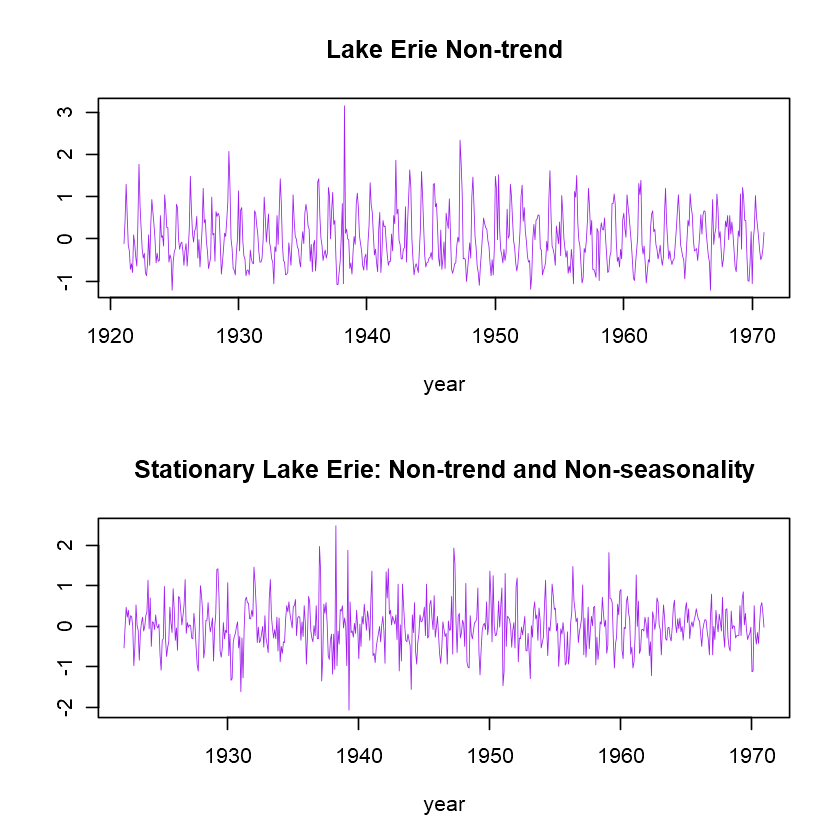

In [8]:
par(mfrow=c(2,1))
plot(diff(data), main='Lake Erie Non-trend', lwd=0.5, xlab='year', ylab='', col='purple')
plot(diff(diff(data),12), main='Stationary Lake Erie: Non-trend and Non-seasonality',
     lwd=0.5, xlab='year', ylab='', col='purple')

# 4. ACF and PACF Plotting
# Order Estimation: MA(q), Seasonal-MA(Q), AR(p), Seasonal-AR(P)

### MA(q) and Seasonal MA(Q)

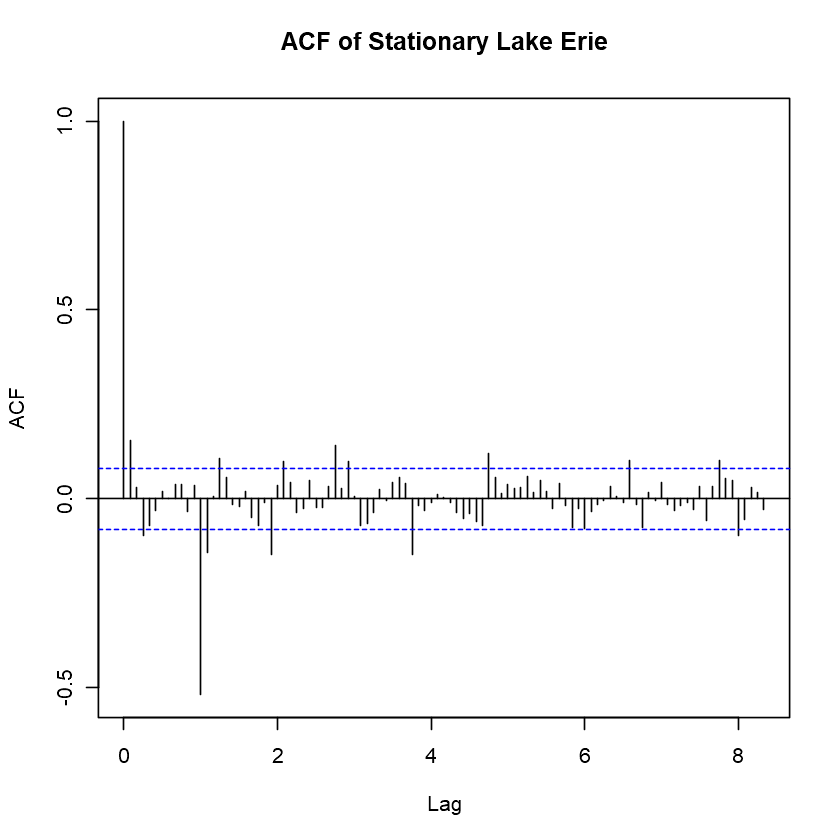

In [9]:
# par(mfrow=c(2,1))  # Use this code if plot is too big
acf(diff(diff(data),12), main='ACF of Stationary Lake Erie', 100)
# acf(diff(diff(data),12), main='ACF of Stationary Lake Erie', 200, plot=F)  # to view only the values

MA(q) and SMA(Q):
Auto-correlation function shows possible significant correlation at lag 1, 3, and maybe 4; lag 0 is never considered because it always has a large spike valued at 1. So our moving average order (MA) order that we will try is 3: that is, MA(3). We seem to have many significant seasonal spikes in muliples of 12 and 13. There are maybe about 12 but since we don't want a model that is that complicated we will try a seasonal moving average order of 5: that is, SMA(5). So, we will build different model using different values of q and Q. q=0,1,2,3 | Q=0,1,2,3,4,5

### AR(p) and Seasonal AR(P)

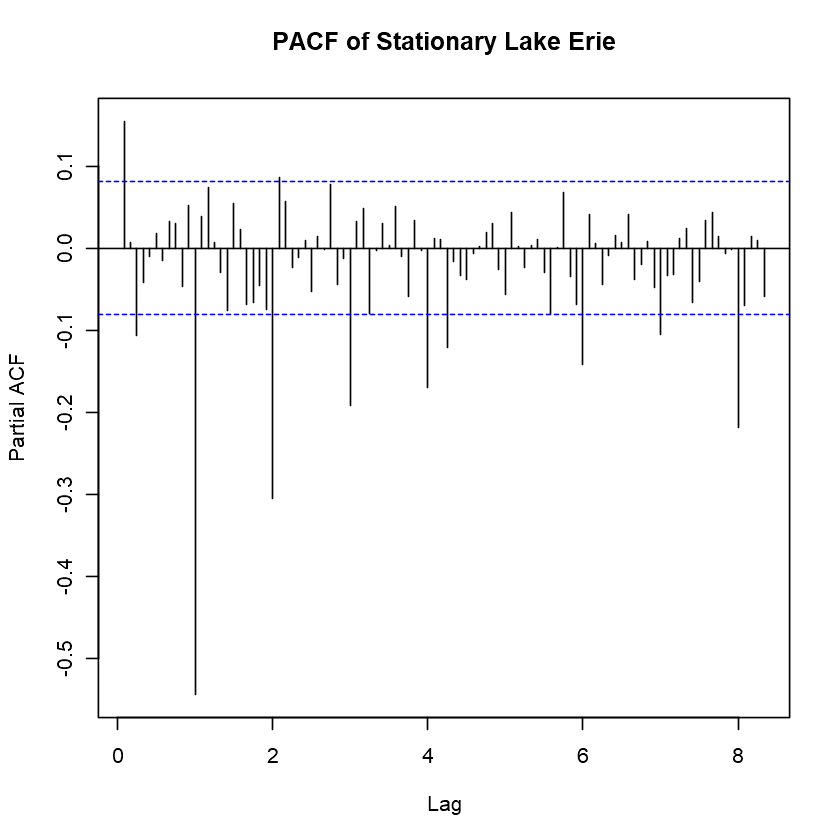

In [10]:
# par(mfrow=c(2,1))  # Use this code if plot is too big  
pacf(diff(diff(data),12), main='PACF of Stationary Lake Erie', 100)
# pacf(diff(diff(data),12), main='PACF of Stationary Lake Erie', plot=F, 100)  # to view only the values

AR(p) and SAR(P):
Partial auto-correlation function shows possible significant correlation at lag 1, 3, and even though lag 4 is a little below significant we will still include it. So our autoregressive order (AR) that we will try is 3: that is, AR(3). We seem to have many significant seasonal spikes in intervals of about 12. There are many but since we don't want a model that is that complicated we will try a seasonal autoregression order of 5: that is, SAR(5). So, we will build different model using different values of p and P. p=0,1,2 | P=0,1,2,3,4,5 

# 5. Building and Fitting Models

We will now test different combinations of AR(p), SAR(P), MA(q), and SMA(Q) order; respectively, autoregression, seasonal autoregression, moving average, and seasonal moving average. The Arima function will be used to test various combinations of our possible orders that we attained from ACF and PACF plots. 
- q=0,1,2,3 
- Q=0,1,2,3,4,5 
- p=0,1,2 
- P=0,1,2,3,4,5  

The Arima function requires the differencing orders which will make the data stationary; non-trend with 0 mean and non-seasonal. To remove the trend from the Lake Erie dataset we differenced the data 1 time. To remove the seasonality, we differenced the data 1 time with a frequency of 12. Seasonal differencing is usually never greater than 2.
- d=1 non-seasonal differencing
- D=1 seasonal differencing


There are several metrics available to help choose the best model. We will print 3 different metrics that give help us choose the best model: 
- Akaike Information Critera (AIC)
- Sum Squared Error (SSE)
- Residual p-value

I primarily use the AIC metric because it penalizes the addition of added terms to the model. This helps us choose as simple of a model as possible; also known as the parsimony principle. Ideally, we would like to keep the sum of p+d+q+P+D+Q ≤ 6 if possible. When multiple models have similar AIC values and same amount of terms (orders), the Box-Ljung statistical test can be applied to the residuals in order to choose the final model. This will produce p-values which are used for the null hypothesis that the residuals have zero autocorrelations; random process. Even though a p-value above significance, ≥0.05, means that we can accept the null hypothesis, the highest p-value model will have the most independent residuals; in other words, white noise. When using these metrics we want low AIC values, low SSE values, and high residual p-values.

In [11]:
# This for-loop code will not work well when the sum of orders q,Q,p,P,d,D becomes large
# and especially when P and Q values above 3; which really means your testing P=0,1,2 and Q=0,1,2.
# If you need to test more orders then use the code block below to manually
# make models one at a time.

d <- NULL  # non-seasonal differencing
D <- NULL  # seasonal differening
num.p.orders <- NULL  # AR
num.P.orders <- NULL  # SAR
num.q.orders <- NULL  # MA
num.Q.orders <- NULL  # SMA
per <- NULL  # Period

d <- 1  # usually not greater than 2
D <- 1  # usually not greater than 2

# Example - If your are trying to find the best model and think that AR(p) order might be 3, then you 
# will write 4 because we want to also test 0 order; p = 0,1,2,3
num.p.orders <- 4
num.P.orders <- 2
num.q.orders <- 4
num.Q.orders <- 2
per <- 12

for(pp in 1:num.p.orders){
  for(qq in 1:num.q.orders){
    for(PP in 1:num.P.orders){
      for(QQ in 1:num.Q.orders){
        if(pp+d+qq+PP+D+QQ<=20){
          model<-arima(x=data, order = c((pp-1),d,(qq-1)), seasonal = list(order=c((PP-1),D,(QQ-1)), period=per))
          pval<-Box.test(model$residuals,type='Ljung-Box', lag=log(length(model$residuals)))
          sse<-sum(model$residuals^2)
          cat(pp-1,d,qq-1,PP-1,D,QQ-1,per, 'AIC=', model$aic, ' SSE=',sse,' residuals p-VALUE=', pval$p.value,'\n')
        }
      }
    }
  }
}

0 1 0 0 1 0 12 AIC= 1025.047  SSE= 196.3709  residuals p-VALUE= 0.0005080869 
0 1 0 0 1 1 12 AIC= 667.3552  SSE= 100.624  residuals p-VALUE= 9.889526e-07 
0 1 0 1 1 0 12 AIC= 839.1351  SSE= 141.6394  residuals p-VALUE= 4.200936e-05 
0 1 0 1 1 1 12 AIC= 669.3551  SSE= 100.6191  residuals p-VALUE= 9.971944e-07 
0 1 1 0 1 0 12 AIC= 1013.694  SSE= 191.9476  residuals p-VALUE= 0.1756393 
0 1 1 0 1 1 12 AIC= 650.1119  SSE= 97.60315  residuals p-VALUE= 0.02356917 
0 1 1 1 1 0 12 AIC= 820.2917  SSE= 136.6527  residuals p-VALUE= 0.1942923 
0 1 1 1 1 1 12 AIC= 651.9933  SSE= 97.72172  residuals p-VALUE= 0.02105381 
0 1 2 0 1 0 12 AIC= 1013.511  SSE= 191.2312  residuals p-VALUE= 0.3686633 
0 1 2 0 1 1 12 AIC= 646.0759  SSE= 96.82791  residuals p-VALUE= 0.2474656 
0 1 2 1 1 0 12 AIC= 820.1648  SSE= 136.1561  residuals p-VALUE= 0.4046266 
0 1 2 1 1 1 12 AIC= 647.6633  SSE= 96.95647  residuals p-VALUE= 0.2376088 
0 1 3 0 1 0 12 AIC= 1012.126  SSE= 190.1276  residuals p-VALUE= 0.7783087 
0 1 3 0 1 1 

Warning message in log(s2):
"NaNs produced"Warning message in log(s2):
"NaNs produced"

3 1 1 1 1 0 12 AIC= 804.7013  SSE= 130.9014  residuals p-VALUE= 0.5657253 
3 1 1 1 1 1 12 AIC= 642.5074  SSE= 95.39031  residuals p-VALUE= 0.9908158 
3 1 2 0 1 0 12 AIC= 1012.915  SSE= 189.0834  residuals p-VALUE= 0.9998673 
3 1 2 0 1 1 12 AIC= 643.0594  SSE= 95.26175  residuals p-VALUE= 0.9897222 
3 1 2 1 1 0 12 AIC= 805.2449  SSE= 130.5807  residuals p-VALUE= 0.7877428 


ERROR: Error in optim(init[mask], armafn, method = optim.method, hessian = TRUE, : non-finite finite-difference value [3]


In [12]:
# Manuel code to compare values for if for-loop code isn't working for the larger orders
model = arima(data, order=c(0,1,2), seasonal=list(order=c(0,1,1), period=12))
pval<-Box.test(model$residuals,type='Ljung-Box', lag=log(length(model$residuals)))
sse<-sum(model$residuals^2)
cat('AIC=',model$aic, ' SSE=',sse, ' residuals p-value=', pval$p.value,'\n')

model = arima(data, order=c(0,1,2), seasonal=list(order=c(1,1,1), period=12))
pval<-Box.test(model$residuals,type='Ljung-Box', lag=log(length(model$residuals)))
sse <-sum(model$residuals^2)
cat('AIC=',model$aic, ' SSE=',sse, ' residuals p-value=', pval$p.value,'\n')

model = arima(data, order=c(1,1,3), seasonal=list(order=c(1,1,1), period=12))
pval<-Box.test(model$residuals,type='Ljung-Box', lag=log(length(model$residuals)))
sse <-sum(model$residuals^2)
cat('AIC=',model$aic, ' SSE=',sse, ' residuals p-value=', pval$p.value)

AIC= 646.0759  SSE= 96.82791  residuals p-value= 0.2474656 
AIC= 647.6633  SSE= 96.95647  residuals p-value= 0.2376088 
AIC= 643.3406  SSE= 95.55074  residuals p-value= 0.9533459

After looking at many models, it appeas that arima(p=3,d=1,q=1,P=0,D=1,Q=1,frequency=12) is our best choice. It has the lowest AIC value of all the models (641.1) and the residual p-value was also very high (0.993). To confirm that our final model selection is exceptional, we want to make sure that its residuals are random noise; zero lag correlation. 
the sarima() function from the astsa package can be used to visually inspect the residuals plot, ACF, Normal Q-Q plot, and p-values. 
- Residuals plot should be random noise
- Residuals ACF should have lags below significance; no autocorrelation
- Residuals Normal Q-Q plot should show no systematic departure from normal distribution
- Residuals p-value for Ljung-Box statiscit should have p-values above significance ≥0.05; accept null hypothesis there is no autocorrelation

initial  value -0.546249 
iter   2 value -0.771281
iter   3 value -0.828918
iter   4 value -0.852643
iter   5 value -0.856849
iter   6 value -0.858925
iter   7 value -0.859222
iter   8 value -0.859334
iter   9 value -0.859376
iter  10 value -0.859506
iter  11 value -0.859886
iter  12 value -0.860568
iter  13 value -0.861086
iter  14 value -0.861135
iter  15 value -0.861185
iter  16 value -0.861205
iter  17 value -0.861288
iter  18 value -0.861492
iter  19 value -0.862004
iter  20 value -0.862227
iter  21 value -0.862352
iter  22 value -0.862520
iter  23 value -0.862605
iter  24 value -0.862616
iter  25 value -0.862628
iter  26 value -0.862643
iter  27 value -0.862644
iter  28 value -0.862644
iter  29 value -0.862644
iter  29 value -0.862644
iter  29 value -0.862644
final  value -0.862644 
converged
initial  value -0.874779 
iter   2 value -0.882749
iter   3 value -0.882959
iter   4 value -0.883036
iter   5 value -0.883043
iter   6 value -0.883043
iter   7 value -0.883044
iter   8 value

$fit

Call:
stats::arima(x = xdata, order = c(p, d, q), seasonal = list(order = c(P, D, 
    Q), period = S), include.mean = !no.constant, optim.control = list(trace = trc, 
    REPORT = 1, reltol = tol))

Coefficients:
         ar1      ar2      ar3      ma1     sma1
      0.7731  -0.0590  -0.1316  -0.5971  -0.9612
s.e.  0.2102   0.0669   0.0438   0.2113   0.0281

sigma^2 estimated as 0.1623:  log likelihood = -314.57,  aic = 641.14

$degrees_of_freedom
[1] 582

$ttable
     Estimate     SE  t.value p.value
ar1    0.7731 0.2102   3.6786  0.0003
ar2   -0.0590 0.0669  -0.8809  0.3787
ar3   -0.1316 0.0438  -3.0035  0.0028
ma1   -0.5971 0.2113  -2.8253  0.0049
sma1  -0.9612 0.0281 -34.1514  0.0000

$AIC
[1] -0.8018693

$AICc
[1] -0.7982999

$BIC
[1] -1.765228


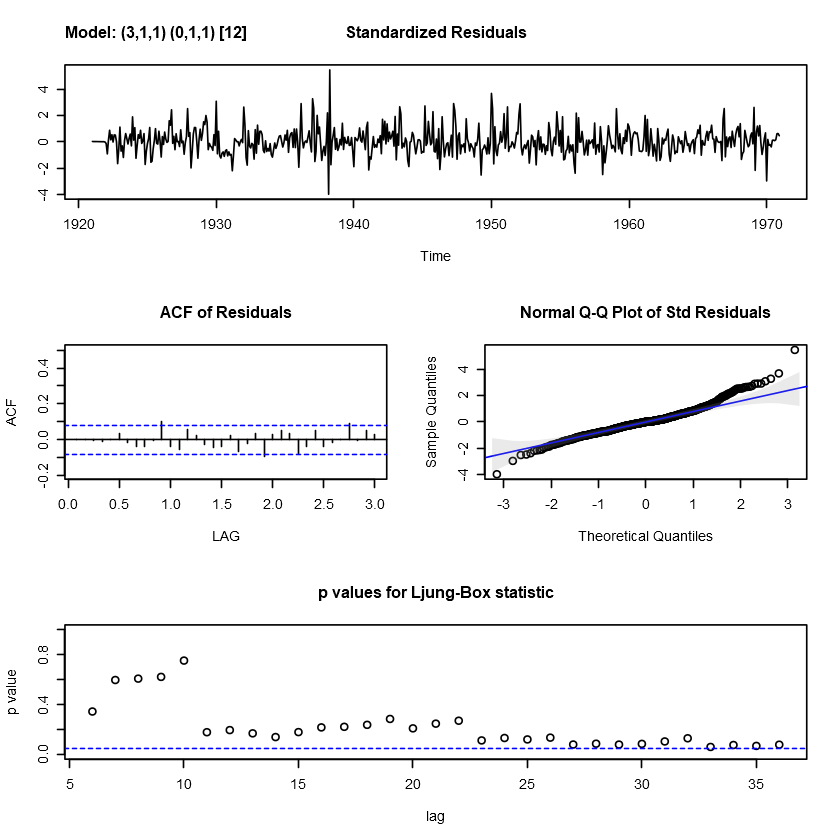

In [13]:
sarima(data, 3,1,1,0,1,1,12)

When running sarima(3,1,1,0,1,1,12), we get a pretty good random noise time plot (except for the random spike before 1940), pretty good ACF of Residuals (except for a extremely tiny bit of autocorellation before lag 3), pretty good distribution of Normal Q-Q plot of Std Residuals (except for some deviation at the end of the tails and an outlier), and a good p-value for Ljung-Box Statisctics plot that shows no autocorellation for the majority of the lags.


The sarima() function also tells us the coefficients for our model and the results are as follows:
- AR(1)  Φ<sub>1</sub> = 0.773
- AR(2)  Φ<sub>2</sub> = -0.059
- AR(2)  Φ<sub>3</sub> = -0.131
- MA(1)  Θ<sub>1</sub> = -0.597   
- SAR(1) # capital theta = -0.961   

The coefficients are used to create the equation for the model. I have created the equation below of what this model looks like with a backshift operator. The formula can be multiplied out and then solved for X<sub>t</sub>.

(1 - Φ<sub>1</sub>ß<sup>1</sup> + Φ<sub>2</sub>ß<sup>2</sup> + Φ<sub>3</sub>ß<sup>3</sup>)(1 - ß<sup>1</sup>)(1 - ß<sup>12</sup>)X<sub>t</sub> = (1 + Θ<sub>1</sub>ß<sup>1</sup>)(1 + Θ<sub>1</sub>ß<sup>12</sup>)Z<sub>t</sub>

**Note the theta before ß<sup>12</sup> on the right side of the equation is supposed to be "capital theta". Also, the ß must be converted to <sub>t-some_number_here</sub> when multiplied out.

# 6. Forecating

The selected model can be used to make forecasts using the forecast() function from the forecast library. The dark shaded area is 80% confidence interval and the lighter shaded area is 95% confidence interval. The default forecast is 2 years ahead and can be changed using the h argument.

In [14]:
selected.model <- arima(data, order=c(3,1,1), seasonal=list(order=c(0,1,1), period=12))

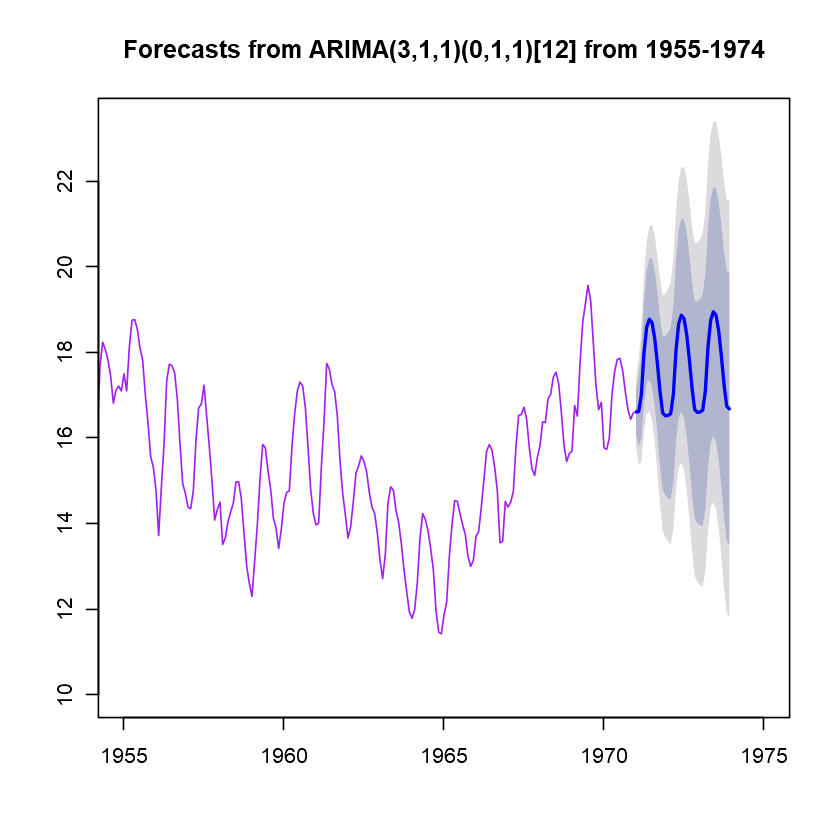

In [15]:
# 3 year forecast
plot(forecast(selected.model, h=36), xlim=c(1955, 1975), col='purple', 
     main='Forecasts from ARIMA(3,1,1)(0,1,1)[12] from 1955-1974')

In [16]:
# 3 year forecast values
forecast(selected.model, h=36)

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 1971       16.60732 16.09067 17.12397 15.81718 17.39747
Feb 1971       16.61334 15.81582 17.41085 15.39364 17.83303
Mar 1971       16.99523 15.96803 18.02243 15.42427 18.56620
Apr 1971       17.98810 16.79606 19.18013 16.16504 19.81116
May 1971       18.58441 17.26840 19.90041 16.57175 20.59706
Jun 1971       18.77265 17.35823 20.18706 16.60949 20.93581
Jul 1971       18.69577 17.19677 20.19477 16.40325 20.98829
Aug 1971       18.33120 16.75478 19.90763 15.92027 20.74214
Sep 1971       17.75313 16.10293 19.40334 15.22936 20.27690
Oct 1971       17.08909 15.36732 18.81086 14.45587 19.72232
Nov 1971       16.58467 14.79317 18.37617 13.84480 19.32453
Dec 1971       16.51646 14.65713 18.37578 13.67286 19.36005
Jan 1972       16.52353 14.59290 18.45415 13.57088 19.47617
Feb 1972       16.56641 14.56598 18.56685 13.50701 19.62581
Mar 1972       17.00663 14.93836 19.07490 13.84348 20.16977
Apr 1972       18.04454 15.91109 20.1780